# Assignment 9: Convolutional Auto-Encoder

In this assignment, we show that it is possible to learn from unlabeled data using a convolutional auto-encoder network. 
The task is to reduce (a noisy version of) an image of the handwritten digits of MNIST into a deep feature representation, without making use of their labels, and reconstruct the sample from that representation.

For this purpose, we implement a convolutional auto-encoder and a denoising auto-encoder that learn a $K=10$-dimensional deep feature representation of each image, and uses this representation to reconstruct images to the original size of $28\times28$ pixels.
We show that such a network can be used to denoise images.

## Dataset

We will make use of the default implementation of the `torchvision.datasets.MNIST` dataset. 
MNIST has 10 labels of digit images.
However, besides the last task, we do not make use of the labels of the dataset, but we only utilize the images.
We instantiate the training and test sets of MNIST -- again we will use the test set for validation purposes.

### Task 1: Datasets

Instantiate the training and validation datasets of MNIST, i.e., split the training and validation sets, and make use of data loaders.
Select a simple `ToTensor` transform.
Instantiate a training data loader using a batch size of $B=32$, and a validation data loader with 100 samples in a batch.

In [1]:
import torch
import torchvision
import numpy as np

B = 32 # batch size

# training set and data loader
train_set = trainset = torchvision.datasets.MNIST(
  root = "./data",
  train=True, download=True, transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size=B)

# validation set and data loader
validation_set = testset = torchvision.datasets.MNIST(
  root = "./data",
  train=False, download=True, transform=torchvision.transforms.ToTensor()
)
validation_loader = torch.utils.data.DataLoader(dataset = validation_set, batch_size=B)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Task 2: Random Noise

Implement a function to generate noisy images by adding a uniform noise to the clean images:

$$\mathbf X_{\mathrm{noise}} = \mathbf X + \alpha \mathbf U^{D\times E}$$ 

where $\mathbf U$ is a tensor with entries generated from a uniform distribution between $-1$ and $1$. 
$D=E=28$ are the width and the height of the original image. 
To represent actual images, we will restrict the pixel values of $\mathbf X_{\mathrm{noise}}$ to be in the range $[0,1]$ by clipping any value that is outside that range.

Note that this function will also be used with batches of samples.

In [2]:
def noise(x, alpha=0.5):
  # generate noise 
  N = np.random.uniform(-1, 1, x.shape)
  # Add noise and clamp
  noisy_sample = torch.clamp(x + alpha * N, 0, 1)

  return noisy_sample

### Noisy Image Visualization

Here we just assure that the images are correct, by displaying them to you.

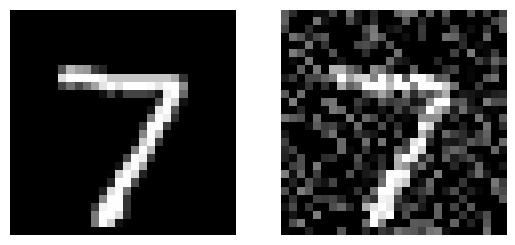

In [3]:
# get first validation image
input = validation_set[0][0]

# generate noise image
noisy = noise(input)

# plot images
from matplotlib import pyplot
pyplot.rcParams['image.cmap'] = 'gray'

fig, ax = pyplot.subplots(1, 2)
ax[0].imshow(input.squeeze())
ax[0].axis("off")
ax[1].imshow(noisy.squeeze())
ax[1].axis("off")
pyplot.show()

## Auto-Encoder Network

The auto-encoder network is composed of two parts: the encoder that transforms the input image to a deep feature representation; and the decoder that produces an image from such a deep feature.

For the encoder $\mathcal E$, we will basically use the same convolutional network topology as in the last assignment.
An exception is that we perform our down-sampling via striding and not via pooling.
After each convolution, we apply the ReLU activation.
The output of the encoder is a $K=10$ dimensional deep feature representation.
The complete encoder network topology can be found below in Topology 1(a).

The decoder $\mathcal D$ performs the inverse operations of the encoder.
A fully-connected layer is used to increase the number of samples to the same size as the output of the flattening of the encoder.
Then, a ReLU activation is applied. 
The flattening needs to be undone next by reshaping the vector into the correct dimensionality.
A fractionally-strided convolutional layer increases the intermediate representation by a factor of 2.
Note that the fractionally-strided convolution is implemented in `torch.nn.ConvTranspose2d`, and the `stride` parameter should have the same value as for the encoder.
Additionally, the `torch.nn.ConvTranspose2d` has a parameter `output_padding` which needs to be adapted to reach the correct output shape (see Test 1).
After this layer, we perform another ReLU activation and another fractionally-strided convolution to arrive at the original input dimension.
The complete decoder network topology can be found below in Topology 1(b).

Finally, we combine the two sub-networks into one auto-encoder network.
While there exist several possibilities for doing this, we will implement a third `torch.nn.Module` that contains an instance of the encoder and an instance of the decoder.

Topology 1: Network configurations of the (a) encoder and (b) decoder networks

(a) Encoder Network

*   2D convolutional layer with $Q_1$ channels, kernel size $5\times5$, **stride 2** and padding 2
*   activation function ReLU
*   2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, **stride 2** and padding 2
*   flatten layer to convert the convolution output into a vector
*   activation function ReLU
*   fully-connected layer with the correct number of inputs and $K$ outputs

(b) Encoder Network

*   fully-connected layer with $K$ inputs and the correct number of outputs
*   activation function ReLU
*   reshaping to convert the vector into a convolution input
*   2D **fractionally-strided convolutional** layer with $Q_2$ channels, kernel size $5\times5$, stride 2 and padding 2
*   activation function ReLU
*   2D **fractionally-strided convolutional** layer with $Q_1$ channels, kernel size $5\times5$, stride 2 and padding 2

### Task 3: Encoder Network

Implement the encoder network for given parameters $Q_1$, $Q_2$, and $K$ as given in Topology 1(a).
Implement a network class that derives from `torch.nn.Module` and implement the `__init__` and the `forward` methods.

In [4]:
class Encoder (torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    # call base class constrcutor
    super(Encoder,self).__init__()
      # define convolutional layers
    self.conv1 = torch.nn.Conv2d(1, Q1, kernel_size= [5,5], stride=2, padding=2)
    self.conv2 = torch.nn.Conv2d(Q1, Q2, kernel_size= [5,5], stride=2, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    # ?? how do I know the size of the input to the first fully-connected layer?
    
    self.fc = torch.nn.Linear(Q2 * 7 * 7, K)


  def forward(self, x):
    # get the deep feature representation
        # compute first layer of convolution, pooling and activation
    a = self.act(self.conv1(x))
    # compute second layer of convolution, pooling and activation
    a = self.act(self.conv2(a))
    # get the deep features as the output of the first fully-connected layer
    # ?? why do I flatten before input to the first fully-connected layer?
    deep_feature = self.act(self.fc(self.flatten(a)))
    return deep_feature

### Task 4: Decoder Network

Implement the decoder network for given parameters $Q_1$, $Q_2$, and $K$ as given in Topology 1(b).
Implement a network class that derives from `torch.nn.Module` and implement the `__init__` and the `forward` methods.
The output of the decoder network is supposed to have values in the range $[0,1]$, similar to the input values.
We need to make sure that only these values can be achieved.
Think of possible ways of doing that, and apply the way that seems most reasonable.

In [5]:
class Decoder (torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    # call base class constrcutor
    super(Decoder,self).__init__()
    # fully-connected layer
    self.fc = torch.nn.Linear(K, Q2 * 7 * 7)
    # convolutional layers
    self.deconv1 = torch.nn.ConvTranspose2d(Q2, Q1, kernel_size= [5,5], stride=2, padding=2, output_padding=1)
    self.deconv2 = torch.nn.ConvTranspose2d(Q1, 1, kernel_size= [5,5], stride=2, padding=2, output_padding=1)
    # activation function
    self.act = torch.nn.ReLU()
    # unflatten
    self.unflatten = torch.nn.Unflatten(dim=1, unflattened_size=(Q2,7,7))
      
  def forward(self, x):
    # reconstruct the output image
    a = self.unflatten(self.act(self.fc(x)))
    a = self.act(self.deconv1(a))
    a = self.deconv2(a)
    output = torch.sigmoid(a)
    return output

In [6]:
import math
def output_dim(features_in, kernel_size, padding, stride, dilation = 1):
    """floor just returns rounded down to nearest int

    :param features_in: _description_
    :type features_in: _type_
    :param kernel_size: _description_
    :type kernel_size: _type_
    :param padding: _description_
    :type padding: _type_
    :param stride: _description_
    :type stride: _type_
    """
    return math.floor((features_in + 2 * padding - dilation * (kernel_size - 1) -1) / stride ) +1

### Task 5: Joint Auto-Encoder Network

Implement the auto-encoder network by combining the encoder and the decoder.
In the `__init__` function, instantiate an encoder from Task 3 and a decoder from Task 4.
In `forward`, pass the input through the encoder and the decoder: $\mathbf Y = \mathcal D(\mathcal E(\mathbf X))$

In [7]:
class AutoEncoder(torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    super(AutoEncoder,self).__init__()
    self.encoder = Encoder(Q1, Q2, K)
    self.decoder = Decoder(Q1, Q2, K)

  def forward(self,x):
    # encode input
    deep_feature = self.encoder(x)
    # decode to output
    reconstructed = self.decoder(deep_feature)
    return reconstructed

### Test 1: Output Sizes

The code below instantiates the auto-encoder network with $Q_1 = Q_2 = 32$ and $K=10$. 
Then the given input $\mathbf X$ is provided to the (untrained) auto-encoder network.
Use this code to verify that the deep feature extracted by the encoder and the output from the decoder part both have the desired size. 
Also, we verify that the output values are between 0 and 1.

If the tests cannot be passed, please check the implementations in Task 3, 4, and 5.

In [8]:
# run on cuda device?
device = torch.device("cuda")
# create network
network = AutoEncoder(32, 32, 10).to(device)

# create or select a sample
x = torch.randn((1,1,28,28))

# use encoder to encode image and check its size
deep_features = network.encoder(x.to(device))
assert deep_features.shape[1] == 10

# use decoder to generate an image and check its size and value range
output = network.decoder(deep_features)
assert output.shape[2:] == (28,28)
assert torch.all(output >= 0) and torch.all(output <= 1)

## Training and Evaluation
We will implement two training procedures, a simple auto-encoder network and a denoising auto-encoder network, which should be combined into one function.
To train the network, we will use the $L_2$ distance between the output and the input of the network as a loss function, which is implemented in `torch.nn.MSELoss`:

  $$\mathcal J^{L_2} (\mathbf X, \mathbf Y) = \|\mathbf X - \mathbf Y\|^2$$

For optimization, we will make use of the `Adam` optimizer with a learning rate of $\eta=0.001$.
We will run the training for 10 epochs and compute training and validation set loss after each epoch.

Denoising training requires generating noisy images before forwarding them into the network and taking the loss between output and the clean image.

For evaluation, we will check whether some of the validation set samples are correctly reconstructed from the auto-encoder network and whether the noise is removed from the denoising network.



### Task 6: Training Loop

For a given network and learning rate, implement a function that initiates loss function (`torch.nn.MSELoss`), optimizer, and trains the network for 10 epochs on the training data.
If parameter `denoise` is `True`, generate noisy batch with factor `alpha`.
Compute the running average of the training loss for each epoch.
At the end of each epoch, also compute the validation set loss.

In [9]:
device = torch.device("cuda")

In [27]:
def training_loop(network, lr=0.001, denoise=False, alpha=0.5):
  # define optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=lr)
  # define loss function
  loss = torch.nn.MSELoss()

  for epoch in range(10):
    # evaluate average loss for training and validation set
    train_loss = validation_loss = 0.

    for x,_ in train_loader:
      optimizer.zero_grad()

      # generate noise images by factor alpha as input if denoise is True
      if denoise:
        x = torch.tensor(noise(x, alpha), dtype=torch.float32)
      
      # compute network output
      y = network(x.to(device))

      # compute loss between output and input
      J = loss(y, x.to(device))
      # perform update
      J.backward()
      optimizer.step()
      # accumulate loss
      train_loss += J.item()


    # compute validation loss
    with torch.no_grad():
      for x,t in validation_loader:
        # generate noise images by factor alpha as input if denoise is True

        # compute network output
        y = network(x.to(device))
        # compute loss
        J = loss(y, x.to(device))
        # accumulate loss
        validation_loss += J.item()


    # print average loss for training and validation
    print(f"\rEpoch {epoch+1}; train: {train_loss/len(train_set):1.5f}, val: {validation_loss/len(validation_set):1.5f}")

### Task 7: Training of two Networks

Instantiate two `AutoEncoder` networks, one to train with only clean samples, and one to train with noisy images. Call the training loop for each network.

Note: If the training loss and validation loss do not decrease during training, try to reduce the learning rate (to $\eta=0.0005$ or even lower) and restart the training.
You will need to re-initialize the network, too.

In [11]:
# define network
network1 = AutoEncoder(32, 32, 10).to(device)

# perform auto-encoder training 
training_loop(network1, lr=0.0005, denoise=False, alpha=0.5)

Epoch 1; train: 0.00144, val: 0.00112
Epoch 2; train: 0.00092, val: 0.00089
Epoch 3; train: 0.00084, val: 0.00084
Epoch 4; train: 0.00080, val: 0.00081
Epoch 5; train: 0.00077, val: 0.00078
Epoch 6; train: 0.00075, val: 0.00077
Epoch 7; train: 0.00074, val: 0.00075
Epoch 8; train: 0.00073, val: 0.00074
Epoch 9; train: 0.00072, val: 0.00073
Epoch 10; train: 0.00071, val: 0.00073


In [28]:
# define network
network1 = AutoEncoder(32, 32, 10).to(device)

# perform auto-encoder training 
training_loop(network1, lr=0.0005, denoise=True, alpha=0.5)

/tmp/ipykernel_52293/1992853878.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(noise(x, alpha), dtype=torch.float32)


Epoch 1; train: 0.00199, val: 0.00167
Epoch 2; train: 0.00179, val: 0.00176
Epoch 3; train: 0.00171, val: 0.00170
Epoch 4; train: 0.00168, val: 0.00165
Epoch 5; train: 0.00165, val: 0.00161
Epoch 6; train: 0.00164, val: 0.00157
Epoch 7; train: 0.00163, val: 0.00155
Epoch 8; train: 0.00162, val: 0.00151
Epoch 9; train: 0.00161, val: 0.00150
Epoch 10; train: 0.00160, val: 0.00148


### Task 8: Reconstruction Result

This task is to visualize the reconstructed images from their originals.
For this purpose, select one image for each label from the first batch of the validation set. 
Generate the noisy input by Task 2.

Forward the clean images through the trained auto-encoder network to extract their reconstructions. 
Forward the noisy inputs through the trained denoising network to remove noise.

To show the difference, plot the original sample, reconstructed sample, noisy sample, and denoised sample for one label in one column. 
Make a single plot with 4 rows and 10 columns. 
See the reference plot in the slides.

/tmp/ipykernel_52293/976784709.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy = torch.tensor(noise(original), dtype=torch.float32).to(device)


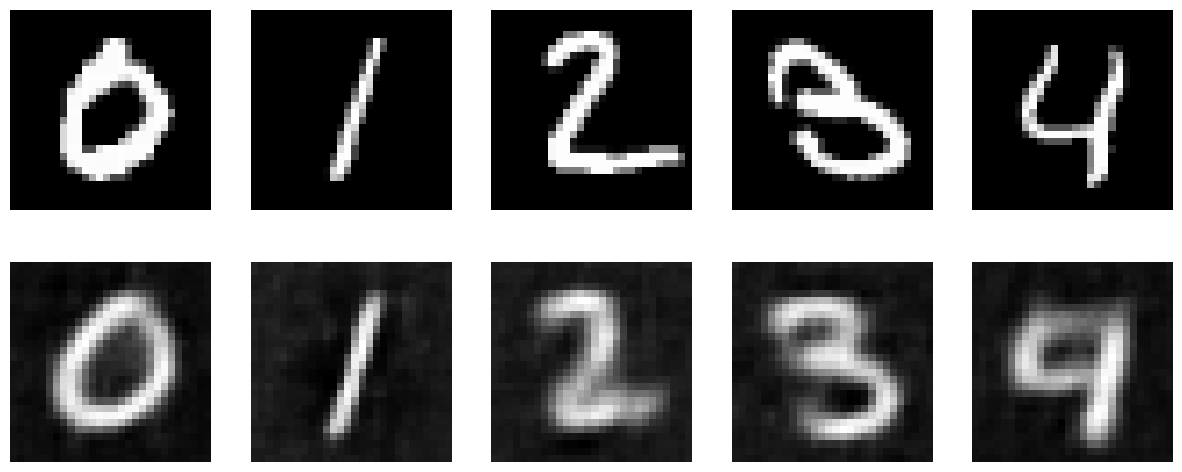

In [29]:

validation_loader = torch.utils.data.DataLoader(dataset = validation_set, batch_size=128)

# get first validation set batch
x,t = next(iter(validation_loader))

# select first image of each class  
select = [ x[t==i][0] for i in range(10) ]


# If required, convert the list of select images into tensor through torch.stack
original = torch.stack(select)

# compute reconstructed samples
reconstructed = network1(original.to(device)).cpu().detach()  
# generate noisy samples
noisy = torch.tensor(noise(original), dtype=torch.float32).to(device)
# compute denoised samples
denoised = network1(noisy).cpu().detach()

samples = [original, reconstructed, noisy, denoised]

# plot images
from matplotlib import pyplot
pyplot.rcParams['image.cmap'] = 'gray'

fig, axes = pyplot.subplots(nrows=2, ncols = 5, figsize=(15, 6))

for i in range(2):
  for j in range(5):
    axes[i][j].imshow(samples[i][j].squeeze())
    axes[i][j].axis("off")